<a href="https://colab.research.google.com/github/LCaravaggio/politext/blob/main/Toda_la_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar la base

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
base=pd.read_csv('/content/drive/MyDrive/base_formateada.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# CV

In [6]:
base['party'].value_counts()

PSOE    189526
PP      144895
Name: party, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
#base['tokens']=base["tokens"].map(' '.join)
X_train, X_test, y_train, y_test = train_test_split(base.loc[:, base.columns != 'party'], base['party'], test_size=0.33, random_state=42)

In [8]:
# Balance de clase
y_train.value_counts()

PSOE    127260
PP       96802
Name: party, dtype: int64

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords=stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Se incorporan las stopwords sugeridas por Federico
stopwords.extend(['señor', 'señora', 'mucha', 'gracia', 'año', 'pasado', 'cada', 'vez', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis' ,'siete', 'ocho', 'nueve', 'diez'])
stopwords.extend(['hoy', 'aquí', 'primer', 'lugar', 'primera', 'segunda', 'primero', 'segundo', 'siguiente', 'tercer'])
stopwords.extend(['convergencia', 'esquerra', 'republicana', 'grupo', 'parlamentaria', 'parlamentario', 'partido'])
stopwords.extend(['enmienda', 'votación', 'favor', 'abstención', 'ley', 'real', 'decreto', 'decretoley', 'resultado', 'voto', 'sé' ,'sí', 'silencio' ,'favor'])
stopwords.extend(['usted', 'señoría', 'presidente', 'presidenta', 'ministro', 'orden' , 'día', 'palabra', 'petición', 'posición', 'punto', 'vista', 'sesión', 'baldoví', 'duran', 'turno'])
stopwords.extend(['hacer', 'frente', 'puede' ,'ser', 'va', 'voy', 'decir'])
stopwords.extend(['millón', 'euro', 'emitido', 'efectuada', 'dio', 'comienzo', 'partido', 'queda', 'quedan', 'rechazada', 'aceptada', 'comienza', 'usted', 'sabe', 'abstención', 'diputado', 'gobierno'])
stopwords.extend(['continuación', 'votamos', 'telemático', 'republicanaizquierda', 'unidainiciativa', 'puede', 'bien', 'propuesta' ,'abstencion', 'mayoría', 'absoluta', 'pregunta', 'don', 'vamos', 'votar', 'llevar', 'cabo', 'millón', 'muchas', 'gracias'])

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=[2,2], max_features=200, stop_words=stopwords, max_df=0.95, min_df=0.001)
vec = cv.fit(X_train['tokens'])

In [12]:
train_matrix = vec.fit_transform(X_train['tokens'])
test_matrix = vec.transform(X_test['tokens'])

# LASSO

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np

In [11]:
lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')

In [12]:
lr.fit(train_matrix,y_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [13]:
predictions = lr.predict(test_matrix)

In [14]:
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[ 8010,  3205],
       [40083, 59061]])

In [15]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          PP       0.17      0.71      0.27     11215
        PSOE       0.95      0.60      0.73     99144

    accuracy                           0.61    110359
   macro avg       0.56      0.65      0.50    110359
weighted avg       0.87      0.61      0.68    110359



In [16]:
# Relevancia de bigramas en la predicción
features=[]
for i,v in enumerate(lr.coef_[0]):
  features.append([vec.get_feature_names_out()[i],v ])

In [17]:
sorted(features, key = lambda x: x[1])

[['número formula', -4.386112500818554],
 ['izquierda plural', -2.246687369413928],
 ['feder izquierda', -2.027482070187739],
 ['nombr popular', -1.563575304839118],
 ['portavoz socialista', -1.419536720368806],
 ['rodríguez zapatero', -1.1977051532104728],
 ['congreso formula', -1.0077379299204308],
 ['interpelación urgent', -0.6793555918603997],
 ['vaya concluyendo', -0.6675016257499847],
 ['diputada doña', -0.6452841956441253],
 ['creación empleo', -0.5258071354404413],
 ['comunidad económica', -0.5103822087129175],
 ['coalición canaria', -0.37392663986613417],
 ['fijación posicion', -0.33659395230602707],
 ['ministerio economía', -0.317999386209088],
 ['déficit público', -0.2656609920534798],
 ['pueblo español', -0.2567847831110033],
 ['desean fijar', -0.25656483055156654],
 ['servicio social', -0.24086835700322248],
 ['sociedad española', -0.23416109460323473],
 ['si quier', -0.20186358929017081],
 ['seguridad jurídica', -0.1970381419439392],
 ['convergència unió', -0.178235895755

In [18]:
# Entiendo que un número negativo en el coeficiente implica que el bigrama correlaciona bien con la clase 0, es decir PP. Por el otro lado, un coeficiente positivo implica que el bigrama correlaciona mejor con PSOE. 
lr.classes_

array(['PP', 'PSOE'], dtype=object)

In [19]:
# LASOO por año
from sklearn.metrics import f1_score

macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')

for x in range(1979,2019): 
  try: 
    base_year=base[pd.DatetimeIndex(base.fecha).year==x]
    X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
    train_matrix = vec.fit_transform(X_train['tokens'])
    test_matrix = vec.transform(X_test['tokens'])  
    lr.fit(train_matrix,y_train)
    predictions = lr.predict(test_matrix )
    macro.append(f1_score(predictions,y_test, average='macro'))
    weighted.append(f1_score(predictions,y_test, average='weighted'))
  except: 
    macro.append(np.nan)
    weighted.append(np.nan)

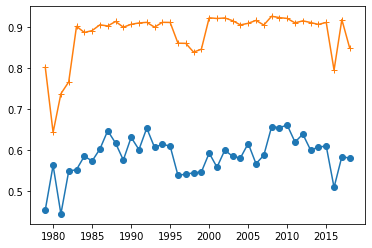

In [20]:
# Yo entiendo que el resultado relevante es el macro, porque considera el desbalance de clases
import matplotlib.pyplot as plt
plt.plot(range(1979,2019), macro, marker='o')
plt.plot(range(1979,2019), weighted, marker='+')

In [21]:
# LASOO por legislatura
macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
legislaturas=['I', 'II', 'III', 'IV', 'V', 'VI', 'VII','VIII', 'IX', 'X', 'XI', 'XII','XIII']

for x in legislaturas: 
  try: 
    base_year=base[base.legislatura==x]
    X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
    train_matrix = vec.fit_transform(X_train['tokens'])
    test_matrix = vec.transform(X_test['tokens'])  
    lr.fit(train_matrix,y_train)
    predictions = lr.predict(test_matrix )
    macro.append(f1_score(predictions,y_test, average='macro'))
    weighted.append(f1_score(predictions,y_test, average='weighted'))
  except: 
    macro.append(np.nan)
    weighted.append(np.nan)

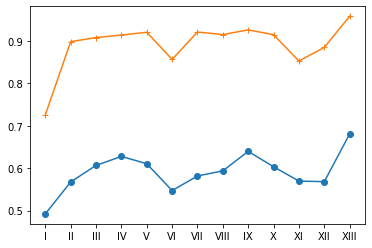

In [22]:
# Yo entiendo que el resultado relevante es el macro, porque considera el desbalance de clases
import matplotlib.pyplot as plt
plt.plot(legislaturas, macro, marker='o')
plt.plot(legislaturas, weighted, marker='+')

In [23]:
# Relevancia de bigramas en la predicción por año
for x in range (1979, 2020): 
  base_year=base[pd.DatetimeIndex(base.fecha).year==x]
  X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
  train_matrix = vec.fit_transform(X_train['tokens'])
  test_matrix = vec.transform(X_test['tokens'])
  lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
  lr.fit(train_matrix,y_train)
  predictions = lr.predict(test_matrix )
  features=[]
  for i,v in enumerate(lr.coef_[0]):
    features.append([vec.get_feature_names_out()[i],v ])
  sor=sorted(features, key = lambda x: x[1])
  print(f"Año: {x}")
  print(sor[:5])
  print(sor[-5:])

Año: 1979
[['publicada boletín', -2.4014323159135205], ['precedido uso', -1.3875972035350186], ['economía mercado', -1.3685275238528096], ['coalición democrática', -1.11362959425207], ['derecho huelga', -0.9211383404412553]]
[['convenio colectivo', 1.167104661428014], ['ministerio interior', 1.2017865279420223], ['sector eléctrico', 1.2954085000687243], ['formacion política', 1.3089267752139657], ['director gener', 1.3303029617284206]]
Año: 1980
[['aprobado artículo', -2.830650770777357], ['pérez royo', -2.3055898774434853], ['artículo pausa', -2.054233436939095], ['senado artículo', -2.0072854105018902], ['número socialista', -1.5494571356011866]]
[['plan urgencia', 1.3621038839942936], ['unión centro', 1.367040279564309], ['justicia militar', 1.3935035044523685], ['formación profesion', 1.516321540949703], ['seguridad jurídica', 1.8582007784604182]]
Año: 1981
[['santa sede', -1.9491474629048882], ['quiero dejar', -1.0255783560318497], ['derecho comparado', -0.9887642329991021], ['por

# LASSO con TF-IDF

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv=TfidfVectorizer(ngram_range=[2,2], max_features=200, stop_words=stopwords, max_df=0.95, min_df=0.01)
vec = cv.fit(X_train['tokens'])

In [25]:
train_matrix = vec.fit_transform(X_train['tokens'])
test_matrix = vec.transform(X_test['tokens'])

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np

In [27]:
lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')

In [28]:
lr.fit(train_matrix,y_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [29]:
predictions = lr.predict(test_matrix)

In [30]:
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[ 86,  24],
       [348, 499]])

In [31]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          PP       0.20      0.78      0.32       110
        PSOE       0.95      0.59      0.73       847

    accuracy                           0.61       957
   macro avg       0.58      0.69      0.52       957
weighted avg       0.87      0.61      0.68       957



In [32]:
# Relevancia de bigramas en la predicción
features=[]
for i,v in enumerate(lr.coef_[0]):
  features.append([vec.get_feature_names_out()[i],v ])

In [33]:
sorted(features, key = lambda x: x[1])

[['confeder unido', -3.3684715986824605],
 ['comú podemen', -2.893051883515266],
 ['convalidación derogación', -2.4929901899481637],
 ['procedimiento urgencia', -2.2274476758490627],
 ['popular congreso', -2.0702461044666753],
 ['miembro diputación', -1.6569717963873647],
 ['pedro sánchez', -0.9160464455108764],
 ['extraordinaria comisión', -0.8465284520674871],
 ['fijación posicion', -0.6802724118556946],
 ['moción censura', -0.6660972692821462],
 ['hace mese', -0.6643961376214127],
 ['medio comunicación', -0.054648047642245304],
 ['proyecto procedimiento', -0.030926814167999455],
 ['unido podemosen', -0.01100594579151438],
 ['podemen marea', -0.00022200814401515833],
 ['acuerd convocatoria', 0.0],
 ['ahora mismo', 0.0],
 ['artículo constitución', 0.0],
 ['buena tard', 0.0],
 ['cambio climático', 0.0],
 ['comisión europea', 0.0],
 ['comunidad autónoma', 0.0],
 ['comú podemgalicia', 0.0],
 ['convocatoria extraordinaria', 0.0],
 ['cuerpo seguridad', 0.0],
 ['derecho libertad', 0.0],
 ['

In [34]:
# Entiendo que un número negativo en el coeficiente implica que el bigrama correlaciona bien con la clase 0, es decir PP. Por el otro lado, un coeficiente positivo implica que el bigrama correlaciona mejor con PSOE. 
lr.classes_

array(['PP', 'PSOE'], dtype=object)

In [35]:
# LASOO por año
from sklearn.metrics import f1_score

macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')

for x in range(1979,2019): 
  try: 
    base_year=base[pd.DatetimeIndex(base.fecha).year==x]
    X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
    train_matrix = vec.fit_transform(X_train['tokens'])
    test_matrix = vec.transform(X_test['tokens'])  
    lr.fit(train_matrix,y_train)
    predictions = lr.predict(test_matrix )
    macro.append(f1_score(predictions,y_test, average='macro'))
    weighted.append(f1_score(predictions,y_test, average='weighted'))
  except: 
    macro.append(np.nan)
    weighted.append(np.nan)

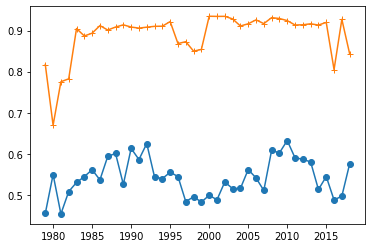

In [36]:
# Yo entiendo que el resultado relevante es el macro, porque considera el desbalance de clases
import matplotlib.pyplot as plt
plt.plot(range(1979,2019), macro, marker='o')
plt.plot(range(1979,2019), weighted, marker='+')

In [37]:
# LASOO por legislatura
macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
legislaturas=['I', 'II', 'III', 'IV', 'V', 'VI', 'VII','VIII', 'IX', 'X', 'XI', 'XII','XIII']

for x in legislaturas: 
  try: 
    base_year=base[base.legislatura==x]
    X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
    train_matrix = vec.fit_transform(X_train['tokens'])
    test_matrix = vec.transform(X_test['tokens'])  
    lr.fit(train_matrix,y_train)
    predictions = lr.predict(test_matrix )
    macro.append(f1_score(predictions,y_test, average='macro'))
    weighted.append(f1_score(predictions,y_test, average='weighted'))
  except: 
    macro.append(np.nan)
    weighted.append(np.nan)

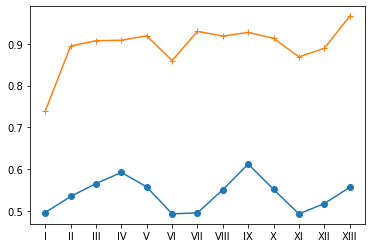

In [38]:
# Yo entiendo que el resultado relevante es el macro, porque considera el desbalance de clases
import matplotlib.pyplot as plt
plt.plot(legislaturas, macro, marker='o')
plt.plot(legislaturas, weighted, marker='+')

In [39]:
# Relevancia de bigramas en la predicción por año
for x in range (1979, 2020): 
  base_year=base[pd.DatetimeIndex(base.fecha).year==x]
  X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
  train_matrix = vec.fit_transform(X_train['tokens'])
  test_matrix = vec.transform(X_test['tokens'])
  lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
  lr.fit(train_matrix,y_train)
  predictions = lr.predict(test_matrix )
  features=[]
  for i,v in enumerate(lr.coef_[0]):
    features.append([vec.get_feature_names_out()[i],v ])
  sor=sorted(features, key = lambda x: x[1])
  print(f"Año: {x}")
  print(sor[:5])
  print(sor[-5:])

Año: 1979
[['publicada boletín', -4.063523799281832], ['coalición democrática', -2.5075061266300205], ['hace falta', -1.2857829154393858], ['precedido uso', -1.2679698186637451], ['economía mercado', -1.2410702496200756]]
[['dictamen comisión', 1.5417117602121064], ['formacion política', 1.5747339418183324], ['convenio colectivo', 1.6425493463706755], ['comité empresa', 1.6554301370650422], ['estatuto trabajador', 1.7373951778636847]]
Año: 1980
[['aprobado artículo', -3.6363482060947083], ['senado artículo', -2.6245428365090078], ['artículo pausa', -2.377891432931062], ['número socialista', -2.051141343157062], ['figura dictamen', -1.5833823817400556]]
[['artículo dice', 2.2645804413037816], ['director gener', 2.4215125360664014], ['formación profesion', 2.5066526432141067], ['tan sólo', 2.7477072711318553], ['justicia militar', 3.2732748684770745]]
Año: 1981
[['impuesto renta', -1.9055018029717647], ['coalición democrática', -1.3968050735554187], ['frail poujad', -1.2472849427926653],

# Regresión lineal

In [40]:
X_train, X_test, y_train, y_test = train_test_split(base.loc[:, base.columns != 'party'], base['party'], test_size=0.33, random_state=42)

In [41]:
vec = cv.fit(X_train['tokens'])

In [42]:
train_matrix = vec.fit_transform(X_train['tokens'])
test_matrix = vec.transform(X_test['tokens'])

In [43]:
y_train.replace(['PSOE', 'PP'],[1, -1], inplace=True)
y_test.replace(['PSOE', 'PP'],[1, -1], inplace=True)

In [44]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [45]:
lr.fit(train_matrix,y_train)

LinearRegression()

In [46]:
predictions = lr.predict(test_matrix)

In [47]:
print(lr.coef_)

[-0.33804904 -0.05274399  0.02903043 -0.27104501 -0.05208874  0.50486513
 -1.16025729  0.10455079 -0.19398949 -0.20063203 -0.08980568 -0.04867194
  0.73896995  0.15294982  0.81528503 -0.23139942 -0.16551829 -0.23952042
  0.08024699 -0.03632334  0.0369103  -0.29147099  0.34662239 -0.15986918
 -0.11727466 -0.03426999 -0.20430329]


In [48]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [49]:
regression_results(y_test,predictions)

explained_variance:  0.0278
r2:  0.0277
MAE:  0.9544
MSE:  0.9562
RMSE:  0.9779


In [50]:
# Relevancia de bigramas en la predicción
features=[]
for i,v in enumerate(lr.coef_):
  features.append([vec.get_feature_names_out()[i],v ])

In [51]:
sorted(features, key = lambda x: x[1])

[['feder izquierda', -1.160257293302511],
 ['administracion pública', -0.3380490359212398],
 ['sociedad española', -0.291470992122777],
 ['convergència unió', -0.27104500594604847],
 ['puesto trabajo', -0.23952042054360018],
 ['política económica', -0.23139942075040412],
 ['unión europea', -0.20430328833340825],
 ['medio ambient', -0.20063202982127845],
 ['izquierda unida', -0.19398948883078493],
 ['presupuesto general', -0.16551829349519845],
 ['tan important', -0.15986917985315252],
 ['toma consideración', -0.11727466010774378],
 ['medio comunicación', -0.08980568158262175],
 ['artículo constitución', -0.05274398664920319],
 ['cualquier caso', -0.052088738785977466],
 ['millon peseta', -0.048671940709840184],
 ['seguridad social', -0.03632333780045771],
 ['tribun constitucion', -0.034269992439611464],
 ['comunidad autónoma', 0.029030428016970627],
 ['servicio público', 0.03691029880686206],
 ['ruego concluya', 0.08024698790516914],
 ['izquierda per', 0.10455079288520995],
 ['mismo ti

# LDA

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

In [53]:
vec = cv.fit(base['tokens'])

In [54]:
matrix = vec.transform(base['tokens'])

In [55]:
lda = LatentDirichletAllocation(n_components=40, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

In [56]:
lda.fit(matrix)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=40, random_state=0)

In [57]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1))
        print(" , ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [58]:
display_topics(lda, feature_names=cv.get_feature_names_out(), no_top_words=20)

Topic 1:
medio comunicación , convergència unió , puesto trabajo , ss ss , seguridad social , artículo constitución , millon peseta , sociedad española , mismo tiempo , política económica , presupuesto general , tan important , administracion pública , per catalunya , medio ambient , izquierda unida , izquierda per , feder izquierda , cualquier caso , servicio público
Topic 2:
convergència unió , unión europea , minoría catalana , artículo constitución , comunidad autónoma , cualquier caso , dictamen comisión , feder izquierda , izquierda per , izquierda unida , medio ambient , medio comunicación , millon peseta , mismo tiempo , tribun constitucion , per catalunya , política económica , presupuesto general , puesto trabajo , ruego concluya
Topic 3:
toma consideración , convergència unió , tan important , artículo constitución , sociedad española , seguridad social , feder izquierda , per catalunya , tribun constitucion , izquierda per , izquierda unida , unión europea , medio ambient ,

In [59]:
# LDA genera una matríz en la que asigna a cada uno de los 200 bigramas una probabilidad de ocurrencia para cada uno de los 40 topics
lda.components_.shape

(40, 27)

# Análisis de coherencia de los topics

In [52]:
from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [5, 10, 20, 40, 60, 80]}

model = LatentDirichletAllocation(n_components=40, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

gridsearch = GridSearchCV(model,
                          param_grid=search_params,
                          n_jobs=-1,
                          verbose=1)
gridsearch.fit(matrix)

## Save the best model
best_lda = gridsearch.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [53]:
cv_results_df = pd.DataFrame(gridsearch.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,249.052693,32.578148,11.980341,0.838963,60,{'n_components': 60},-744030.815082,-1.963705e+06,-2.407715e+06,-2.044233e+06,-1.671276e+06,-1.766192e+06,5.624398e+05,1
1,277.798329,35.864818,14.125421,2.273873,80,{'n_components': 80},-748655.452532,-2.770818e+06,-3.383716e+06,-3.017663e+06,-2.507264e+06,-2.485623e+06,9.152594e+05,2
2,275.270251,1.823028,13.590462,0.972290,100,{'n_components': 100},-772376.264201,-3.267241e+06,-4.037386e+06,-3.594920e+06,-2.957313e+06,-2.925847e+06,1.134738e+06,3
3,316.872495,37.367340,15.280507,1.685737,120,{'n_components': 120},-811247.726253,-3.774591e+06,-4.701272e+06,-4.191575e+06,-3.426793e+06,-3.381096e+06,1.353572e+06,4
4,309.584425,68.145277,15.086198,4.232081,140,{'n_components': 140},-836263.188794,-4.271791e+06,-5.353030e+06,-4.765904e+06,-3.870801e+06,-3.819558e+06,1.571897e+06,5


<AxesSubplot:xlabel='param_n_components', ylabel='mean_test_score'>

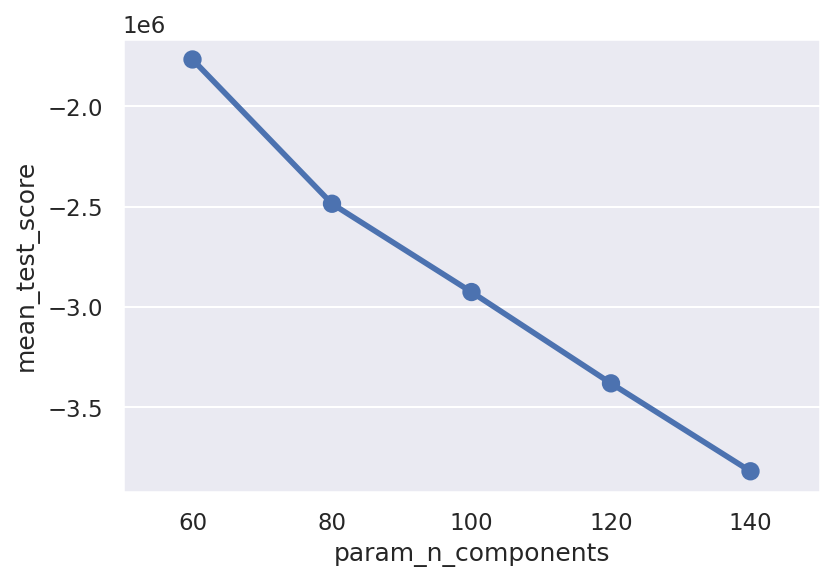

In [54]:
import seaborn as sns
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.pointplot(x="param_n_components",
              y="mean_test_score",
              data=cv_results_df)

# NNMF

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
nmf = NMF(n_components=40, random_state=1).fit(matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [ ]:
display_topics(nmf, feature_names=cv.get_feature_names_out(),  no_top_words=20)

Topic 1:
comunidad madrid , unido podemo , toda españa , formación profesion , acuerd convocatoria , posicion mixto , acuerdo retirada , suficient miembro , estatuto gernika , política española , convocatoria extraordinaria , presentar nombr , gasto público , relacion cort , tribun supremo , resolv problema , marco financiero , buena tard , mercado labor , comú podemgalicia
Topic 2:
vasco legarda , comisión europea , salvamento marítimo , encima mesa , pleno cámara , derecho libertad , comparecencia ministra , igualdad oportunidad , cuerpo seguridad , rodríguez hernández , crisi económica , tribun constitucion , presupuesto general , adoptar medida , tribun supremo , relacion cort , podemgalicia común , hombr mujer , resolv problema , estatuto autonomía
Topic 3:
sistema público , pesca alimentación , quiero decirl , política migratoria , suficient miembro , presentar nombr , legarda uriart , ministra hacienda , crecimiento económico , salida reino , llegar acuerdo , proyecto procedimie